In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from lib.feature_extractor import extraction_model as em
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from externals.d2net.lib import localization, utils
from lib import autoencoder, attention_model
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv
from lib import correspondence_datamodule
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform
import cv2
from lib import load_checkpoint
import seaborn as sns

In [82]:
EncoderModule = autoencoder.FeatureEncoder64Up
AttentionModule = attention_model.MultiAttentionLayer

#resnet parameters
replace_strides = False
use_nms = False # set to false to visualize attention
thresh = 0.2
max_features=None
first_stride=1
use_gpu=True

encoder_ckpt = load_checkpoint.get_encoder_ckpt('correspondence_encoder')
attention_ckpt = load_checkpoint.get_attention_ckpt('multiattention_dest_N32')

if replace_strides:
    replace_stride_with_dilation = (True, True, True) #(True, True, True) # Default: (False, False, False)
    num_upsampling_extraction = 2
    no_upsampling = True # Set to true when replacing strides
else: 
    replace_stride_with_dilation = (False, False, False)
    num_upsampling_extraction = 3
    no_upsampling = False

if first_stride == 1:
    num_upsampling_extraction -= 1


In [83]:
pair_idx = 4
assert(pair_idx in [1, 2, 3, 4, 5, 6])
pair_path = os.path.join('qualitative/images', f'pair_{pair_idx}')

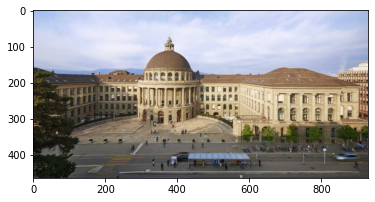

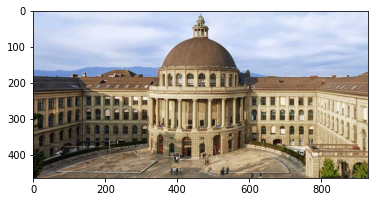

In [84]:
img = Image.open(os.path.join(pair_path, '1.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image1_np = np.array(img)#[200:, :]
img = Image.open(os.path.join(pair_path, '2.jpg'))
#img = img.resize([img.size[0]*2, img.size[1]*2])
image2_np = np.array(img)#[200:, :]
image1 = utils.preprocess_image(image1_np)
image1 = torch.as_tensor(image1)
image1 = torch.unsqueeze(image1, 0)
image2 = utils.preprocess_image(image2_np)
image2 = torch.as_tensor(image2)
image2 = torch.unsqueeze(image2, 0)

if use_gpu:
    image1 = image1.cuda()
    image2 = image2.cuda()

plt.imshow(image1_np)
plt.show()
plt.imshow(image2_np)
plt.show()

In [94]:
# encoder = DummyEncoder().eval()
# attention = attention_model.MultiAttentionLayer(encoder).eval()

# extraction_model = em.ExtractionModel(attention, use_d2net_detection=False, num_upsampling=4, thresh=0.0)
encoder = EncoderModule.load_from_checkpoint(encoder_ckpt,
                                             no_upsampling=no_upsampling,
                                             replace_stride_with_dilation=replace_stride_with_dilation, 
                                             first_stride=first_stride,
                                             load_tf_weights=False).eval()

#encoder = DummyEncoder().eval()
#attention = attention_model.MultiAttentionLayer(encoder).eval()
attention = AttentionModule.load_from_checkpoint(attention_ckpt, feature_encoder=encoder).eval()

extraction_model = em.ExtractionModel(attention, 
                                      use_d2net_detection=True, 
                                      num_upsampling=num_upsampling_extraction, 
                                      thresh=thresh, 
                                      max_features=max_features,
                                      use_nms=use_nms)

if use_gpu:
    extraction_model = extraction_model.cuda()

In [95]:
kp1, descr1, scores1, det1 = extraction_model(image1)
kp2, descr2, scores2, det2 = extraction_model(image2)

# For dummy encoder, we get 3 times the same output
s1 = scores1.size()[0] #// 3
print(f'{scores1.size()[0]} --> {s1}')
kp1 = kp1[:s1, :].numpy()
descr1 = descr1[:s1, :].numpy()
scores1 = scores1[:s1]

s2 = scores2.size()[0] #// 3
print(f'{scores2.size()[0]} --> {s2}')
kp2 = kp2[:s2, :].numpy()
descr2 = descr2[:s2, :].numpy()
scores2 = scores2[:s2]


3612 --> 3612
3624 --> 3624


In [96]:
matches = match_descriptors(descr1, descr2, cross_check=True)
n_matches = len(matches)
print(len(matches))

967


In [97]:
keypoints_left = kp1[matches[:, 0], : 2]
keypoints_right = kp2[matches[:, 1], : 2]
np.random.seed(0)
model, inliers = ransac(
    (keypoints_left, keypoints_right),
    ProjectiveTransform, min_samples=4,
    residual_threshold=4, max_trials=10000
)
n_inliers = np.sum(inliers)
print('Number of inliers: %d.' % n_inliers)

Number of inliers: 64.


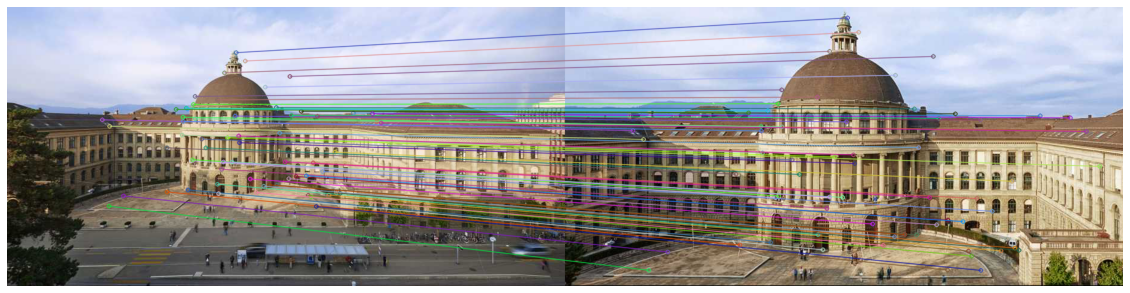

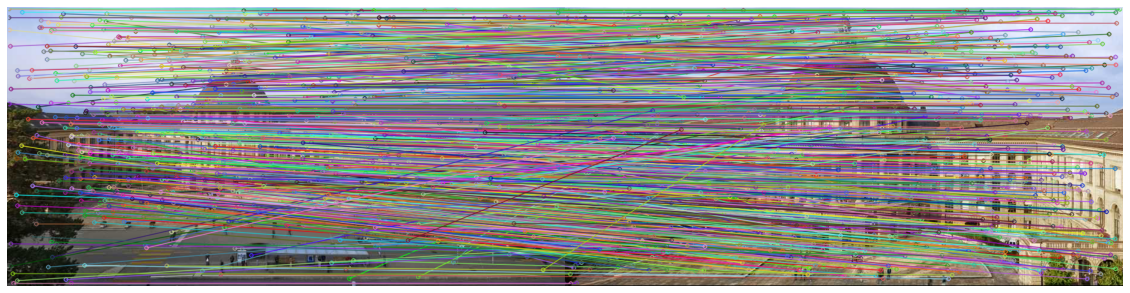

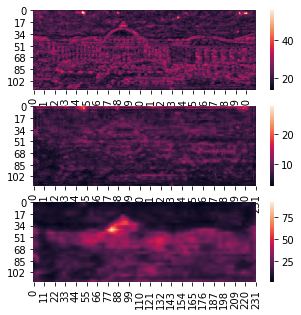

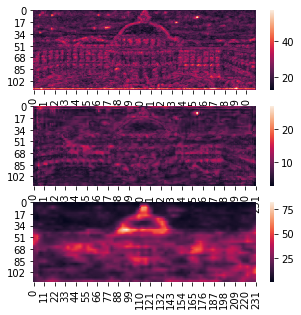

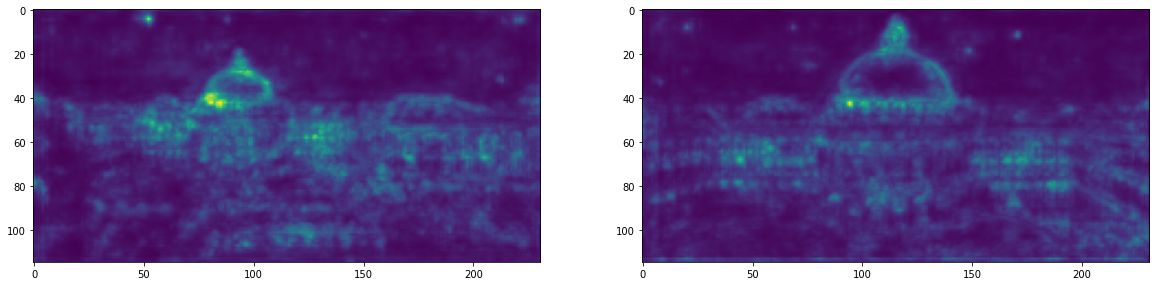

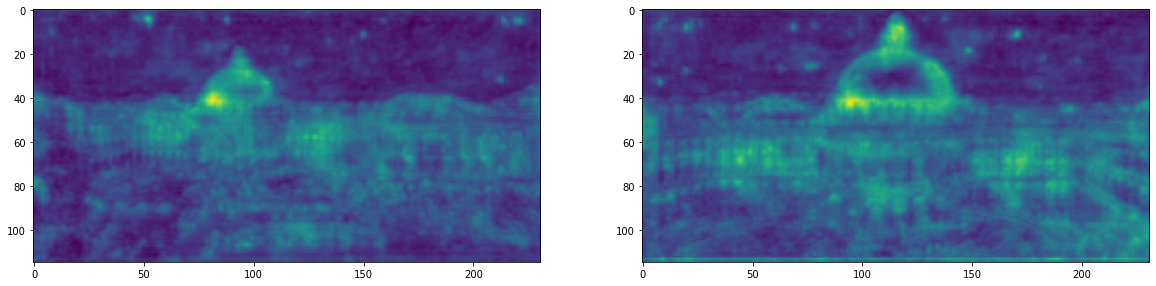

In [98]:
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left[inliers]]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right[inliers]]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
image3 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

#print(keypoints_left[inliers])
#print(keypoints_right[inliers])


plt.figure(figsize=(20, 20))
plt.imshow(image3)
plt.axis('off')
plt.show()

inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_matches)]
image4 = cv2.drawMatches(image1_np, inlier_keypoints_left, image2_np, inlier_keypoints_right, placeholder_matches, None)

plt.figure(figsize=(20, 20))
plt.imshow(image4)
plt.axis('off')
plt.show()

fig, axs = plt.subplots(3,1, figsize=(5, 5))
sns.heatmap(det1[0], ax=axs[0])
sns.heatmap(det1[1], ax=axs[1])
sns.heatmap(det1[2], ax=axs[2])
plt.show()

fig, axs = plt.subplots(3,1, figsize=(5, 5))
sns.heatmap(det2[0], ax=axs[0])
sns.heatmap(det2[1], ax=axs[1])
sns.heatmap(det2[2], ax=axs[2])
plt.show()

h1 = min([d.shape[0] for d in det1])
w1 = min([d.shape[1] for d in det1])
h2 = min([d.shape[0] for d in det2])
w2 = min([d.shape[1] for d in det2])
att_mult1 = det1[0][:h1, :w1] * det1[1][:h1, :w1] * det1[2][:h1, :w1]
att_mult2 = det2[0][:h2, :w2] * det2[1][:h2, :w2] * det2[2][:h2, :w2]

fig, axs = plt.subplots(1,2, figsize=(20, 20))
axs[0].imshow(att_mult1)
axs[1].imshow(att_mult2)
plt.show()

att_mult1 = det1[0][:h1, :w1] + det1[1][:h1, :w1] + det1[2][:h1, :w1]
att_mult2 = det2[0][:h2, :w2] + det2[1][:h2, :w2] + det2[2][:h2, :w2]

fig, axs = plt.subplots(1,2, figsize=(20, 20))
axs[0].imshow(att_mult1)
axs[1].imshow(att_mult2)
plt.show()

In [99]:
# You can use below to visialize the offsets

In [100]:
# class DummyEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = tv.models.resnet50(pretrained=True)
#         self.extractor = correspondence_datamodule.ResnetActivationExtractor(self.model)
#         self.encoded_channels=1024
    
#     def forward(self, image):
#         a = self.extractor(image)
#         return {
#             'early': a['layer3_conv3'],
#             'middle': a['layer3_conv3'],
#             'deep': a['layer3_conv3'],
#         }

In [101]:
# encoder = EncoderModule.load_from_checkpoint('/home/mark/eth/enc.ckpt',
#                                              no_upsampling=no_upsampling,
#                                              strides=strides, 
#                                              replace_stride_with_dilation=replace_stride_with_dilation, 
#                                              first_stride=first_stride,
#                                              load_tf_weights=False).eval()

# #encoder = DummyEncoder().eval()
# #attention = attention_model.MultiAttentionLayer(encoder).eval()
# attention = attention_model.MultiAttentionLayer.load_from_checkpoint('/home/mark/eth/attent.ckpt', feature_encoder=encoder).eval()

# extraction_model = em.ExtractionModel(attention, 
#                                       use_d2net_detection=False, 
#                                       num_upsampling=num_upsampling_extraction, 
#                                       thresh=thresh, 
#                                       max_features=max_features)
# image = Image.open('/home/mark/Downloads/test.jpg')
# image_np = np.array(image)
# image = utils.preprocess_image(image_np)
# image = torch.as_tensor(image)
# image = torch.unsqueeze(image, 0)

# keypoints, descriptors, scores, detections = extraction_model(image)

# print(scores.size())
# print(detections[0].shape)
# row, col = np.nonzero(detections[0])
# row *= image_np.shape[0]

# plt.imshow(image_np)
# plt.scatter(keypoints[:, 0], keypoints[:, 1])
# row, col = np.nonzero(detections[0])
# row = row.astype(np.float32)
# col = col.astype(np.float32)
# row *= image_np.shape[0]/detections[0].shape[0]
# col *= image_np.shape[1]/detections[0].shape[1]
# plt.scatter(col+8, row+8)
# row, col = np.nonzero(detections[1])
# row = row.astype(np.float32)
# col = col.astype(np.float32)
# row *= image_np.shape[0]/detections[1].shape[0]
# col *= image_np.shape[1]/detections[1].shape[1]
# plt.scatter(col+8, row+8)
# row, col = np.nonzero(detections[2])
# row = row.astype(np.float32)
# col = col.astype(np.float32)
# row *= image_np.shape[0]/detections[2].shape[0]
# col *= image_np.shape[1]/detections[2].shape[1]
# plt.scatter(col+8, row+8)
# plt.show()
# plt.imshow(detections[0])
# plt.show()
# plt.imshow(detections[1])
# plt.show()
# plt.imshow(detections[2])